In [1]:
import pandas as pd
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Import the data
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

2022-03-31 15:16:28.680014: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


In [3]:
from utils.dataset import get_data_masks
import numpy as np

# load the model
classifier = tf.keras.models.load_model('../in/digit_classifier')

# load the predictions
predictions = np.loadtxt('../in/predictions.csv')
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the masks for the data
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5, verbose=True)


Found 892/10000 instances for the label 5
Found 13/892 instances for misclassified 5
        


In [4]:
base_dir = '../out/insights'

In [5]:
from utils.general import beep
from workflow.tuning import find_optimal_clusters
from xplique.attributions import GradCAMPP, SmoothGrad, IntegratedGradients, Rise, KernelShap, Lime
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from workflow.ClusteringMode import LocalLatentMode

batch_size=64
explainers = [
        GradCAMPP(classifier),
        SmoothGrad(classifier, nb_samples=50, noise=.3, batch_size=batch_size),
        IntegratedGradients(classifier, steps=50, batch_size=batch_size),
        Rise(classifier, nb_samples=4000, batch_size=batch_size),
        KernelShap(classifier, nb_samples=1000),
        Lime(classifier, nb_samples=1000)
    ]

approaches = [
    LocalLatentMode(
        mask=mask_label,
        explainer=explainer,
        dim_red_techs=[TSNE(perplexity=3)],
        clus_tech=AffinityPropagation()
    )
    for explainer in explainers
]

local_latent_df = find_optimal_clusters(
    approaches=approaches,
    data=test_data,
    predictions=predictions_cat,
    iterations=5,
    verbose=True
)

beep()


APPROACH: LocalLatentMode
EXPLAINER: GradCAMPP
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 3, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}]
            
1/5 -> 0.40294697880744934
2/5 -> 0.39510732889175415
3/5 -> 0.40360793471336365
4/5 -> 0.37686681747436523
5/5 -> 0.38169243931770325

APPROACH: LocalLatentMode
EXPLAINER: SmoothGrad
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 3, 'random_state': None, 'squ

In [6]:
local_latent_df.to_csv(f'{base_dir}/local_latent.csv', index=False)

In [8]:
from workflow.ClusteringMode import GlobalLatentMode

approaches = [
    GlobalLatentMode(
        mask=mask_label,
        explainer=explainer,
        dim_red_techs=[TSNE(perplexity=5)],
        clus_tech=AffinityPropagation()
    )
    for explainer in explainers
]

global_latent_df = find_optimal_clusters(
    approaches=approaches,
    data=test_data,
    predictions=predictions_cat,
    iterations=5,
    verbose=True
)

beep()


APPROACH: GlobalLatentMode
EXPLAINER: GradCAMPP
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 5, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}]
            
1/5 -> 0.3815918564796448
2/5 -> 0.3729611933231354
3/5 -> 0.354221910238266
4/5 -> 0.3706367313861847
5/5 -> 0.40380123257637024

APPROACH: GlobalLatentMode
EXPLAINER: SmoothGrad
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 5, 'random_state': None, 'square

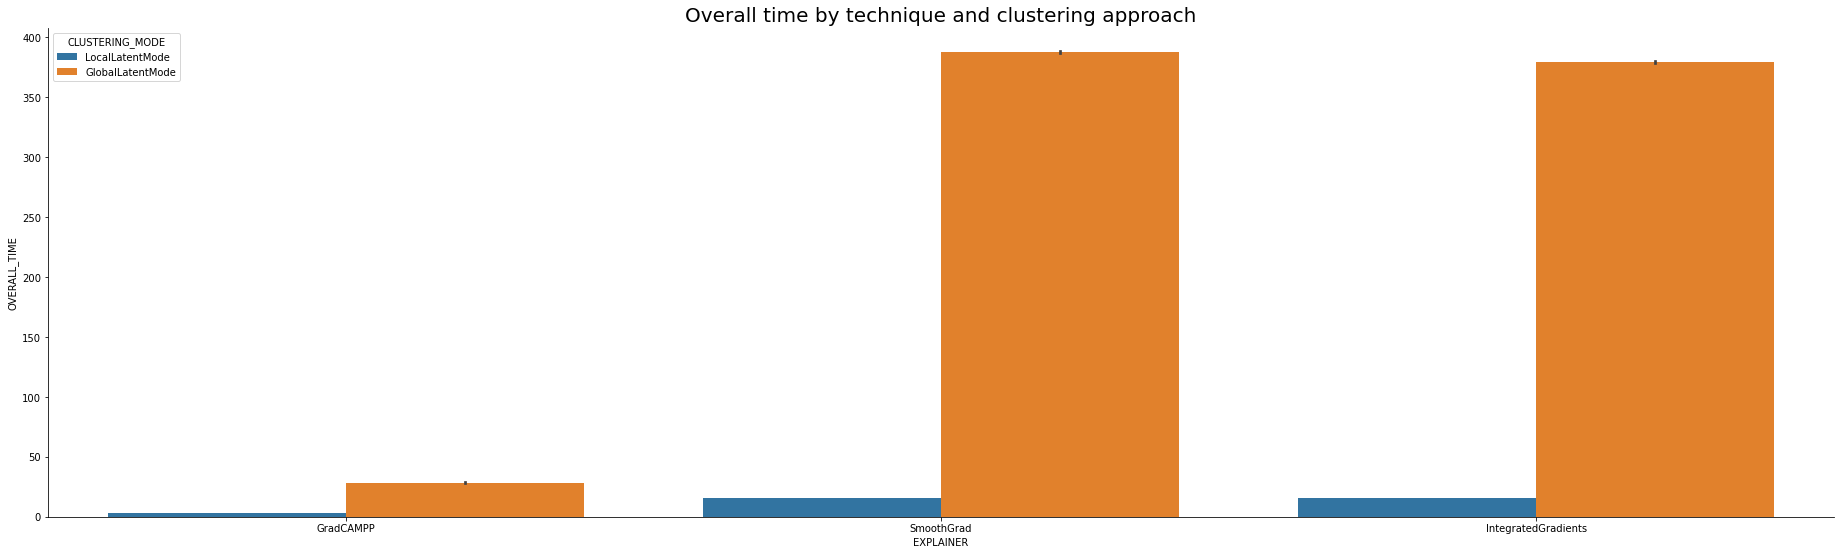

In [20]:
from utils.general import save_figure
import seaborn as sns

overall_df = pd.concat([local_latent_df, global_latent_df])
overall_df['OVERALL_TIME'] = overall_df['TIME_CONTRIBUTIONS'] + overall_df['TIME_CLUSTERING']
overall_df = overall_df[~overall_df['EXPLAINER'].isin(['Rise', 'KernelShap', 'Lime'])]

avg_time =overall_df.groupby(['EXPLAINER', 'CLUSTERING_MODE'])['OVERALL_TIME'].mean().reset_index(drop=False)

fig, ax = plt.subplots(1, 1, figsize=(16*2, 9))
# sns.boxplot(x='EXPLAINER', y='SILHOUETTE', hue='CLUSTERING_MODE', data=overall_df, ax=ax[0], showfliers=False).set_title('Quality scores by technique and clustering approach', size=20)
sns.barplot(x='EXPLAINER', y='OVERALL_TIME', hue='CLUSTERING_MODE', data=overall_df, ax=ax).set_title('Overall time by technique and clustering approach', size=20)
fig.show()
sns.despine()

save_figure(fig, '../out/insights/local_latent_scores_by_technique', dpi=300)

In [9]:
best_row = df.sort_values(by=['SILHOUETTE'], ascending=False).iloc[0]
best_row.to_dict()

{'MODEL': 'MNIST',
 'EXPLAINER': 'Rise',
 'CLUSTERING_TECHNIQUE': 'AffinityPropagation',
 'DIMENSIONALITY_REDUCTION_TECHNIQUE': 'TSNE',
 'DISTANCE_METRIC': nan,
 'CLUSTERING_MODE': 'LocalLatentMode',
 'CLUSTERS': '0,1,1,0,2,3,0,3,2,2',
 'SILHOUETTE': 0.984,
 'TIME_CONTRIBUTIONS': 4.66701,
 'TIME_CLUSTERING': 0.15898,
 'TIMESTAMP': '2022-03-29 00:18:28.958831'}